In [1]:
from expetator.tools import read_experiment, show_heatmap, add_objectives
from expetator.tools import prune_vectors, mojitos_to_vectors, show_pct_distribution
from expetator.monitors import mojitos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from random import sample 

In [8]:
all_knowledge = pd.read_csv("../EDA and visualization/knowledge_allmetrics.csv")
all_vectors = pd.read_csv("../EDA and visualization/vectors_allmetrics.csv")
ignore_columns = ['irxp', 'irxb','itxp', 'itxb', 'core0','core1']
all_vectors = all_vectors.loc[:,~ all_vectors.columns.isin(ignore_columns)]
vectors = prune_vectors(all_vectors)

vectors['expe'] = all_knowledge.expe
vectors['target'] = all_knowledge['target']
metric_mapping = {
    "energy":0,
    "duration":1,
    "etp":2
}
vectors['metric'] = all_knowledge['metric'].map(metric_mapping)

In [4]:
exps = list(set(vectors.expe))
testidx = sample(exps, int(0.2*len(exps)))

In [10]:
train = vectors[~vectors.expe.isin(testidx)].reset_index(drop=True)
test = vectors[vectors.expe.isin(testidx)].reset_index(drop=True)

## training and evaluation

In [13]:
skf = GroupKFold(n_splits=5)
train['Kfold'] = -1
train['group'] = train.apply(lambda row: str(row['expe']) + str(row['metric']),axis = 1)
for i, (train_index, test_index) in enumerate(skf.split(train, train.target, groups = train['group'])):
    print("Fold: ",i, "VAL:", test_index)
    train.loc[list(test_index),'Kfold'] = i

Fold:  0 VAL: [   26    27    28 ... 38180 38181 38182]
Fold:  1 VAL: [   78    79    80 ... 38258 38259 38260]
Fold:  2 VAL: [   39    40    41 ... 38245 38246 38247]
Fold:  3 VAL: [    0     1     2 ... 38271 38272 38273]
Fold:  4 VAL: [   13    14    15 ... 38206 38207 38208]


In [31]:
ignore_columns = ['expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]
for FOLD in range(5):
    X_train = train.loc[train.Kfold != FOLD, ~train.columns.isin(ignore_columns)]
    y_train = train.loc[train.Kfold != FOLD,'target']
    X_val = train.loc[train.Kfold == FOLD, ~train.columns.isin(ignore_columns)]
    y_val = train.loc[train.Kfold == FOLD,'target']
    
    sc = StandardScaler()
    df_train = sc.fit_transform(X_train)
    df_val = sc.transform(X_val)

    df_Xtrain_sc = pd.DataFrame(df_train,columns = X_train.columns)
    df_Xval_sc = pd.DataFrame(df_val,columns = X_train.columns)

    df_Ytrain = y_train.reset_index(drop=True)
    df_Yval = y_val.reset_index(drop=True)
    
    clf = xgb.XGBClassifier(objective="multi:softprob",n_estimators=5500,learning_rate = 0.1, max_depth=10,gamma=0.0,min_child_weight=1,subsample = 0.8,colsample_bytree = 0.8, random_state=42 )
    clf.fit(df_Xtrain_sc, df_Ytrain, eval_metric=['merror'], eval_set=[(df_Xtrain_sc, df_Ytrain),(df_Xval_sc,df_Yval)], verbose=False, early_stopping_rounds=100)
    
    preds = clf.predict(df_Xval_sc)
    accuracy = accuracy_score(df_Yval, preds)
    print(f"FOLD{FOLD}-val acc: {(accuracy * 100.0)}", end=' ')
    X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
    df_test = sc.transform(X_test)
    df_test_sc = pd.DataFrame(df_test,columns = X_test.columns)
    y_test = test.target.reset_index(drop=True)

    preds = clf.predict(df_test_sc)
    accuracy = accuracy_score(y_test, preds)
    print(f"FOLD{FOLD}-test acc: {(accuracy * 100.0)}")

FOLD0-val acc: 81.25408229915088 FOLD0-test acc: 74.95025657136874
FOLD1-val acc: 78.83736120182887 FOLD1-test acc: 75.25395329353859
FOLD2-val acc: 79.72566949706075 FOLD2-test acc: 74.40569693161588
FOLD3-val acc: 78.82429784454604 FOLD3-test acc: 74.3952246308514
FOLD4-val acc: 79.09589756989809 FOLD4-test acc: 74.79317205990156


In [32]:
ignore_columns = ['expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]
for FOLD in range(5):
    X_train = train.loc[train.Kfold != FOLD, ~train.columns.isin(ignore_columns)]
    y_train = train.loc[train.Kfold != FOLD,'target']
    X_val = train.loc[train.Kfold == FOLD, ~train.columns.isin(ignore_columns)]
    y_val = train.loc[train.Kfold == FOLD,'target']
    
    sc = StandardScaler()
    df_train = sc.fit_transform(X_train)
    df_val = sc.transform(X_val)

    df_Xtrain_sc = pd.DataFrame(df_train,columns = X_train.columns)
    df_Xval_sc = pd.DataFrame(df_val,columns = X_train.columns)

    df_Ytrain = y_train.reset_index(drop=True)
    df_Yval = y_val.reset_index(drop=True)
    
    clf = xgb.XGBClassifier(objective="multi:softprob",n_estimators=5500,learning_rate = 0.1, max_depth=10,gamma=1.0,min_child_weight=1,subsample = 0.8,colsample_bytree = 0.8, random_state=42 )
    clf.fit(df_Xtrain_sc, df_Ytrain, eval_metric=['merror'], eval_set=[(df_Xtrain_sc, df_Ytrain),(df_Xval_sc,df_Yval)], verbose=False, early_stopping_rounds=100)
    
    preds = clf.predict(df_Xval_sc)
    accuracy = accuracy_score(df_Yval, preds)
    print(f"FOLD{FOLD}-val acc: {(accuracy * 100.0)}", end=' ')
    X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
    df_test = sc.transform(X_test)
    df_test_sc = pd.DataFrame(df_test,columns = X_test.columns)
    y_test = test.target.reset_index(drop=True)

    preds = clf.predict(df_test_sc)
    accuracy = accuracy_score(y_test, preds)
    print(f"FOLD{FOLD}-test acc: {(accuracy * 100.0)}")

FOLD0-val acc: 80.26126714565643 FOLD0-test acc: 75.02356267672008
FOLD1-val acc: 77.93598954931417 FOLD1-test acc: 75.05497957901352
FOLD2-val acc: 79.30764206401045 FOLD2-test acc: 74.76175515760812
FOLD3-val acc: 78.51077726975832 FOLD3-test acc: 74.66750445072783
FOLD4-val acc: 78.83459628952181 FOLD4-test acc: 74.8664781652529


In [22]:
FOLD = 4
ignore_columns = ['expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]
X_train = train.loc[train.Kfold != FOLD, ~train.columns.isin(ignore_columns)]
y_train = train.loc[train.Kfold != FOLD,'target']
X_val = train.loc[train.Kfold == FOLD, ~train.columns.isin(ignore_columns)]
y_val = train.loc[train.Kfold == FOLD,'target']

In [23]:
sc = StandardScaler()
df_train = sc.fit_transform(X_train)
df_val = sc.transform(X_val)

df_Xtrain_sc = pd.DataFrame(df_train,columns = X_train.columns)
df_Xval_sc = pd.DataFrame(df_val,columns = X_train.columns)

df_Ytrain = y_train.reset_index(drop=True)
df_Yval = y_val.reset_index(drop=True)

In [24]:
df_Xtrain_sc.columns

Index(['ref_cpu_cycles', 'cpu_clock', 'branch_misses', 'cache_references',
       'page_faults', 'context_switches', 'cpu_cycles', 'cache_dtlb',
       'cache_op_read', 'cache_node', 'task_clock', 'bus_cycles', 'cache_l1d',
       'cache_itlb', 'branch_instructions', 'cache_misses', 'cache_ll',
       'cache_bpu', 'cache_op_prefetch', 'cpu_migrations',
       'cache_result_access', 'instructions', 'rxp', 'rxb', 'txp',
       'package-00', 'dram0', 'package-11', 'user', 'system', 'idle', 'iowait',
       'softirq', 'freq', 'metric'],
      dtype='object')

In [30]:
clf = xgb.XGBClassifier(objective="multi:softprob",n_estimators=5500,learning_rate = 0.1, max_depth=10,gamma=0.0,min_child_weight=1,subsample = 0.7,colsample_bytree = 0.7, random_state=42 )
clf.fit(df_Xtrain_sc, df_Ytrain, eval_metric=['merror'], eval_set=[(df_Xtrain_sc, df_Ytrain),(df_Xval_sc,df_Yval)], verbose=True, early_stopping_rounds=100)

[0]	validation_0-merror:0.26653	validation_1-merror:0.39835
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 100 rounds.
[1]	validation_0-merror:0.20062	validation_1-merror:0.32846
[2]	validation_0-merror:0.16695	validation_1-merror:0.29096
[3]	validation_0-merror:0.14847	validation_1-merror:0.28012
[4]	validation_0-merror:0.14001	validation_1-merror:0.27737
[5]	validation_0-merror:0.12681	validation_1-merror:0.27097
[6]	validation_0-merror:0.12008	validation_1-merror:0.26039
[7]	validation_0-merror:0.11646	validation_1-merror:0.25817
[8]	validation_0-merror:0.11130	validation_1-merror:0.25359
[9]	validation_0-merror:0.10692	validation_1-merror:0.24967
[10]	validation_0-merror:0.10206	validation_1-merror:0.24980
[11]	validation_0-merror:0.09957	validation_1-merror:0.24993
[12]	validation_0-merror:0.09497	validation_1-merror:0.24745
[13]	validation_0-merror:0.09007	validation_1-merror:

[132]	validation_0-merror:0.00000	validation_1-merror:0.21597
[133]	validation_0-merror:0.00000	validation_1-merror:0.21675
[134]	validation_0-merror:0.00000	validation_1-merror:0.21505
[135]	validation_0-merror:0.00000	validation_1-merror:0.21583
[136]	validation_0-merror:0.00000	validation_1-merror:0.21505
[137]	validation_0-merror:0.00000	validation_1-merror:0.21531
[138]	validation_0-merror:0.00000	validation_1-merror:0.21544
[139]	validation_0-merror:0.00000	validation_1-merror:0.21583
[140]	validation_0-merror:0.00000	validation_1-merror:0.21570
[141]	validation_0-merror:0.00000	validation_1-merror:0.21518
[142]	validation_0-merror:0.00000	validation_1-merror:0.21544
[143]	validation_0-merror:0.00000	validation_1-merror:0.21597
[144]	validation_0-merror:0.00000	validation_1-merror:0.21623
[145]	validation_0-merror:0.00000	validation_1-merror:0.21636
[146]	validation_0-merror:0.00000	validation_1-merror:0.21597
[147]	validation_0-merror:0.00000	validation_1-merror:0.21570
[148]	va

[265]	validation_0-merror:0.00000	validation_1-merror:0.21401
[266]	validation_0-merror:0.00000	validation_1-merror:0.21427
[267]	validation_0-merror:0.00000	validation_1-merror:0.21374
[268]	validation_0-merror:0.00000	validation_1-merror:0.21414
[269]	validation_0-merror:0.00000	validation_1-merror:0.21388
[270]	validation_0-merror:0.00000	validation_1-merror:0.21388
[271]	validation_0-merror:0.00000	validation_1-merror:0.21348
[272]	validation_0-merror:0.00000	validation_1-merror:0.21374
[273]	validation_0-merror:0.00000	validation_1-merror:0.21427
[274]	validation_0-merror:0.00000	validation_1-merror:0.21440
[275]	validation_0-merror:0.00000	validation_1-merror:0.21401
[276]	validation_0-merror:0.00000	validation_1-merror:0.21414
[277]	validation_0-merror:0.00000	validation_1-merror:0.21388
[278]	validation_0-merror:0.00000	validation_1-merror:0.21401
[279]	validation_0-merror:0.00000	validation_1-merror:0.21388
[280]	validation_0-merror:0.00000	validation_1-merror:0.21401
[281]	va

[398]	validation_0-merror:0.00000	validation_1-merror:0.21087
[399]	validation_0-merror:0.00000	validation_1-merror:0.21100
[400]	validation_0-merror:0.00000	validation_1-merror:0.21113
[401]	validation_0-merror:0.00000	validation_1-merror:0.21100
[402]	validation_0-merror:0.00000	validation_1-merror:0.21074
[403]	validation_0-merror:0.00000	validation_1-merror:0.21074
[404]	validation_0-merror:0.00000	validation_1-merror:0.21100
[405]	validation_0-merror:0.00000	validation_1-merror:0.21126
[406]	validation_0-merror:0.00000	validation_1-merror:0.21113
[407]	validation_0-merror:0.00000	validation_1-merror:0.21100
[408]	validation_0-merror:0.00000	validation_1-merror:0.21100
[409]	validation_0-merror:0.00000	validation_1-merror:0.21126
[410]	validation_0-merror:0.00000	validation_1-merror:0.21126
[411]	validation_0-merror:0.00000	validation_1-merror:0.21152
[412]	validation_0-merror:0.00000	validation_1-merror:0.21152
[413]	validation_0-merror:0.00000	validation_1-merror:0.21139
[414]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5500, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [52]:
feature_important = clf.get_booster().get_score(importance_type='weight')

In [53]:
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.to_csv('importance_feature_cf.csv')

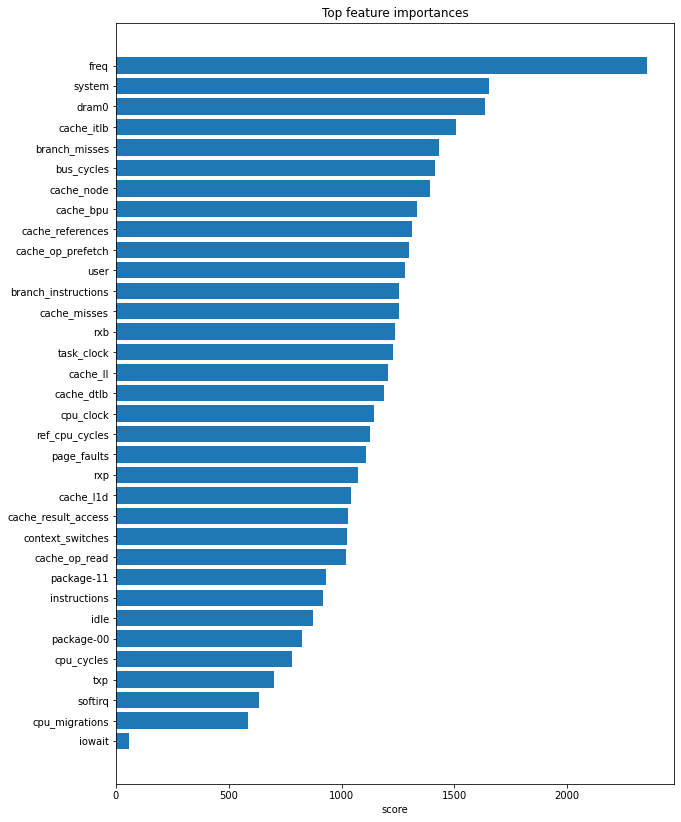

In [54]:
objects = data.index
y_pos = np.arange(len(objects))
performance = data['score']

plt.figure(figsize=(10,14))
plt.barh(y_pos, performance, align='center')
plt.yticks(y_pos, objects)
plt.xlabel('score')
plt.title('Top feature importances')
plt.show()

In [57]:
preds = clf.predict(df_Xval_sc)
accuracy = accuracy_score(df_Yval, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.29%


In [203]:
labels = list(set(df_Ytest))
labels.sort()

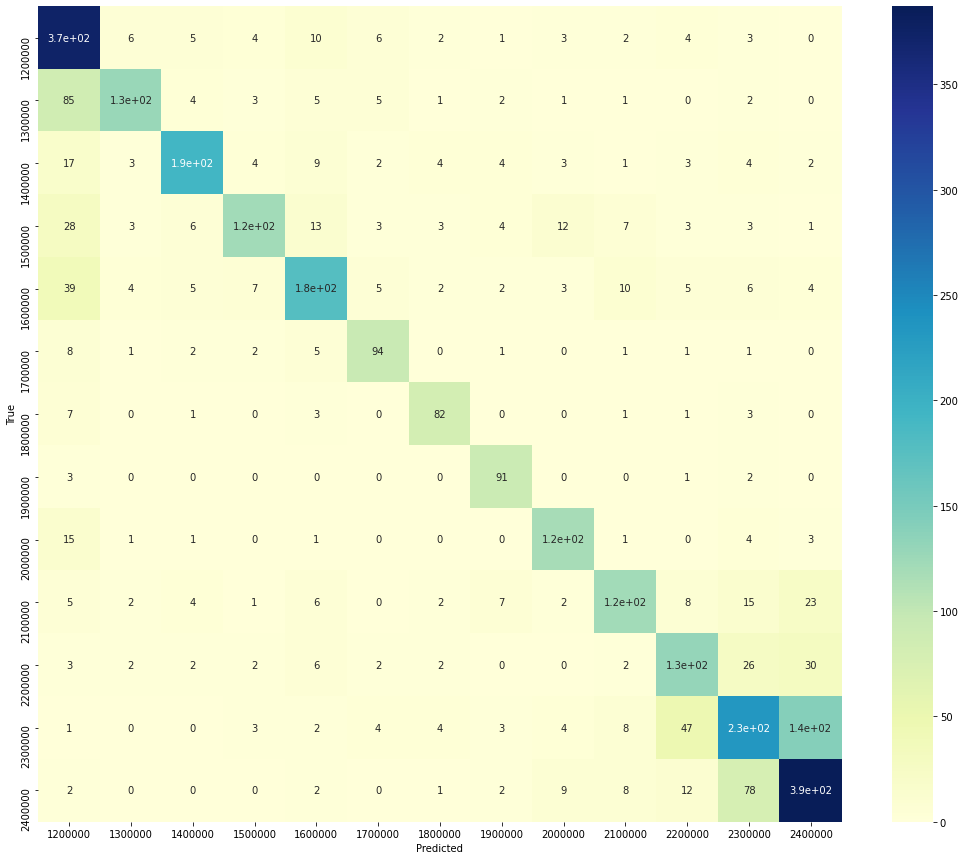

In [205]:
cfm = confusion_matrix(df_Ytest, preds, labels = labels)
plt.figure(figsize=(18,15))
ax = sns.heatmap(cfm, annot=True, cmap="YlGnBu")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
df_test = sc.transform(X_test)
df_test_sc = pd.DataFrame(df_test,columns = X_test.columns)
y_test = test.target.reset_index(drop=True)

preds = clf.predict(df_test_sc)
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.51%
